# Example 2: Differential expression scatterplots

This example looks more closely at using the results table part of :mod:`metaseq`, and highlights the flexibility in plotting afforded by :mod:`metaseq`.

In [1]:
# Enable in-line plots for this IPython Notebook
%matplotlib inline

##Setup

In this section, we'll get the example data for control and knockdown samples, combine the data, and and create :class:`ResultsTable` object out of them.

If you haven't already done so, run the `download_metaseq_example_data.py` script, which will download and prepare from public sources.

Import what we'll be using:

In [2]:
import metaseq
from metaseq import example_filename
from metaseq.results_table import ResultsTable
import pandas
import numpy as np
import matplotlib
import pybedtools
import gffutils
from gffutils.helpers import asinterval
import os

We'll be using tables prepared from Cufflinks GTF output from GEO entries GSM847565 and GSM847566.  These represent results control and ATF3 knockdown experiments in the K562 human cell line.  You can read more about the data on GEO; this example will be more about the features of :mod:`metaseq` than the biology.

Let's get the example files:

In [3]:
%%bash
example_dir="metaseq-example"
if [ -e $example_dir ]; then echo "already exists";
else
    mkdir -p $example_dir
    (cd $example_dir \
    && wget --progress=dot:giga https://raw.githubusercontent.com/daler/metaseq-example-data/master/metaseq-example-data.tar.gz \
    && tar -xzf metaseq-example-data.tar.gz \
    && rm metaseq-example-data.tar.gz)
fi

already exists


In [4]:
data_dir = 'metaseq-example/data'
control_filename = os.path.join(data_dir, 'GSM847565_SL2585.table')
knockdown_filename = os.path.join(data_dir, 'GSM847566_SL2592.table')

Let's take a quick peak to see what these files look like:

In [5]:
# System call; IPython only!
!head -n5 $control_filename

id	score	fpkm
ENST00000456328	108.293110992801	1.1183355144
ENST00000515242	87.2330185289764	0.8306172562
ENST00000518655	175.175608597549	2.3676823979
ENST00000473358	343.232678519699	9.7952652359


As documented at http://cufflinks.cbcb.umd.edu/manual.html#gtfout, the `score` field indicates relative expression of one isoform compared to other isoforms of the same gene, times 1000.  The max score is 1000, and an isoform with this score is considered the major isoform.  A score of 800 would mean an isoform's FPKM is 0.8 that of the major isoform.

If you're working with DESeq results, the :mod:`metaseq.results_table.DESeqResults` class is a nice wrapper around those results with one-step import.  But here, we'll construct a `pandas.DataFrame` first and then create a `ResultsTable` object out of it.

In [6]:
# Create two pandas.DataFrames

control = pandas.read_table(control_filename, index_col=0)
knockdown = pandas.read_table(knockdown_filename, index_col=0)

Here's what the first few entries look like:

In [7]:
control.head()

,score,fpkm
id,,
ENST00000456328,108.293111,1.118336
ENST00000515242,87.233019,0.830617
ENST00000518655,175.175609,2.367682
ENST00000473358,343.232679,9.795265
ENST00000408384,0.000000,0.000000


In [8]:
knockdown.head()

,score,fpkm
id,,
ENST00000456328,290.752543,6.503301
ENST00000515242,253.364453,4.790326
ENST00000518655,23.190962,0.174388
ENST00000473358,510.475081,33.409877
ENST00000408384,0.000000,0.000000


These are two separate objects.  It will be easier to work with the data if we first combine the data into a single dataframe.  For this we will use standard `pandas` routines:

In [9]:
# Merge control and knockdown into one DataFrame

df = pandas.merge(control, knockdown, left_index=True, right_index=True, suffixes=('_ct', '_kd'))
df.head()

,score_ct,fpkm_ct,score_kd,fpkm_kd
id,,,,
ENST00000456328,108.293111,1.118336,290.752543,6.503301
ENST00000515242,87.233019,0.830617,253.364453,4.790326
ENST00000518655,175.175609,2.367682,23.190962,0.174388
ENST00000473358,343.232679,9.795265,510.475081,33.409877
ENST00000408384,0.000000,0.000000,0.000000,0.000000


Now we'll create a :class:`metaseq.results_table.ResultsTable` out of it:

In [10]:
# Create a ResultsTable

d = ResultsTable(df)

:class:`ResultsTable` objects are wrappers around `pandas.DataFrame` objects, and are useful for working with annotations and tablular data.  You can always access the `DataFrame` with the `.data` attribute:

In [11]:
# DataFrame is always accessible via .data

print type(d), type(d.data)

<class 'metaseq.results_table.ResultsTable'> <class 'pandas.core.frame.DataFrame'>


The `metaseq` example data includes a GFF file of the genes on chromosome 17 of the hg19 human genome assembly:

In [12]:
# Get gene annotations for chr17

gtf = os.path.join(data_dir, 'Homo_sapiens.GRCh37.66_chr17.gtf')
print open(gtf).readline()

chr17	protein_coding	exon	30898	31270	.	-	.	 gene_id "ENSG00000187939"; transcript_id "ENST00000343572"; exon_number "1"; gene_name "DOC2B"; gene_biotype "protein_coding"; transcript_name "DOC2B-201";



## Subsetting data

The data we loaded from the knockdown experiment contains genes from all chromosomes.  For the sake of argument, let's say we're only interested in the expression data for these genes on chr17.  We can simply use `pandas.DataFrame.ix` to subset dataframe by a list of genes.  Note that for this to work, the items in the list need to be in the index of the dataframe.  Since the data frame index consists of Ensembl transcript IDs, we'll need to create a list of Ensembl transcript IDs on chromosome 17:

In [13]:
# Get a list of transcript IDs on chr17, and subset the dataframe.

# Here we use pybedtools, but the list of names can come from anywhere
names = list(set([i['transcript_id'] for i in pybedtools.BedTool(gtf)]))
names.sort()

# Make a copy of d
d2 = d.copy()

# And subset
d2.data = d2.data.ix[names]

# How many did we omit?
print "original:", len(d.data)
print "chr17 subset:", len(d2.data)

original: 85699
chr17 subset: 5708


## Scatterplots

Let's plot some data.  The :meth:`ResultsTable.scatter` method helps with plotting genome-wide data, and offers lots of flexibility.  

For its most basic usage, we need to at least supply `x` and `y`.  These are names of variables in the dataframe.  We'll add more data later, but for now, let's plot the FPKM of control vs knockdown:

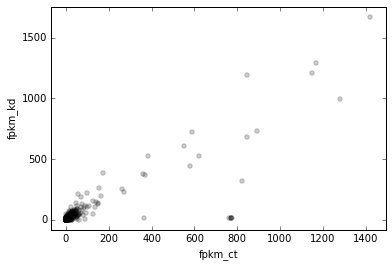

In [14]:
# Scatterplot of control vs knockdown FPKM
d2.scatter(
    x='fpkm_ct',
    y='fpkm_kd');

If you're following along in a terminal with interactive `matplotlib` plots, you can click on a point to see what gene it is.  In this IPython Notebook (and the HTML documentation generated from it), we don't have that interactive ability.  We can simulate it here by choosing a gene ID to show, and then manually call the `_default_callback` like this:


In [15]:
# arbitrary gene for demonstration purposes
interesting_gene = np.argmax(d2.fpkm_ct)
interesting_gene

'ENST00000253788'

In [16]:
# What happens if you were to click on the points in an interactive session
d2._default_callback(interesting_gene)

score_ct    1047.517457
fpkm_ct     1422.448488
score_kd    1070.752317
fpkm_kd     1671.190119
Name: ENST00000253788, dtype: float64


Clicking around interactively on the points is a great way to get a feel for the data.

OK, it looks like this plot could use log scaling.  Recall though that the `ResultsTable.scatter` method needs to have `x` and `y` variables available in the dataframe.  So one way to do this would be to do something like this:

In [17]:
# Adding extra variables gets verbose and cluttered
d2.data['log_fpkm_ct'] = np.log1p(d2.data.fpkm_ct)

But when playing around with different scales, this quickly pollutes the dataframe with extra columns.  Let's delete that column . . .

In [18]:
# We'll use a better way, so delete it.
del d2.data['log_fpkm_ct']

. . . and show another way. 

You may find it more streamlined to use the `xfunc` and/or `yfunc` arguments.  We can use any arbitrary function for these, and the axes labels will reflect that.

Since we're about to start incrementally improving the figure by adding additional keyword arguments (kwargs), the stuff we've already talked about will be at the top, and a comment line like this will mark the start of new stuff to pay attention to:
    
    # -------------  (marks the start of new stuff)
 
Here's the next version of the scatterplot: 

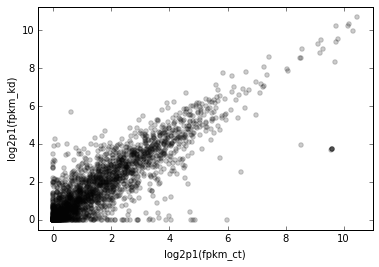

In [19]:
# Scale x and y axes using log2(x + 1)

def log2p1(x):
    return np.log2(x + 1)

d2.scatter(
    x='fpkm_ct',
    y='fpkm_kd',
    #----------------
    xfunc=log2p1,
    yfunc=log2p1,
    );

Of course, we can specify axes labels either directly in the method call with `xlab` or `ylab`, or after the fact using standard `matplotlib` functionality:

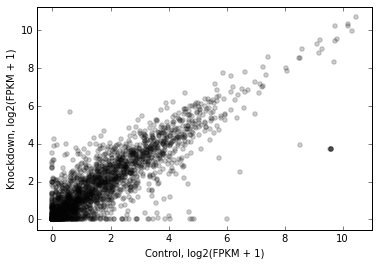

In [20]:
# Manually specify x and y labels

ax = d2.scatter(
    x='fpkm_ct',
    y='fpkm_kd',
    xfunc=log2p1,
    yfunc=log2p1,
    
    #-----------------------------
    # specify xlabel
    xlab='Control, log2(FPKM + 1)'
    );

# adjust the ylabel afterwards
ax.set_ylabel('Knockdown, log2(FPKM + 1)');
                

Let's highlight some genes.  How about those that change expression > 2 fold in upon knockdown in red, and < 2 fold in blue?  While we're at it, let's add another variable to the dataframe.

In [21]:
# Crude differential expression detection....

d2.data['foldchange'] = d2.fpkm_kd / d2.fpkm_ct
up = (d2.foldchange > 2).values
dn = (d2.foldchange < 0.5).values

The way to highlight genes is with the `genes_to_highlight` argument.  OK, OK, it's a little bit of a misnomer here because we're actually working with transcripts.  But the idea is the same. 

The `genes_to_highlight` argument takes a list of tuples.  Each tuple consists of two items: an index (boolean or integer, doesn't matter) and a style dictionary.  This dictionary is passed directly to `matplotlib.scatter`, so you can use any supported arguments here.

Here's the plot with up/downregulated genes highlighted:

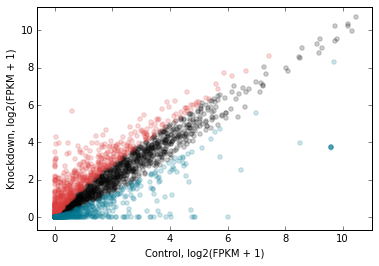

In [22]:
# Use the genes_to_highlight argument to show up/downregulated genes
# in different colors

d2.scatter(
    x='fpkm_ct',
    y='fpkm_kd',
    xfunc=log2p1,
    yfunc=log2p1,
    xlab='Control, log2(FPKM + 1)',
    ylab='Knockdown, log2(FPKM + 1)',
    #-------------------------------
    genes_to_highlight=[
        (up, dict(color='#da3b3a')),
        (dn, dict(color='#00748e'))]
    );          

We can add a 1-to-1 line for reference:

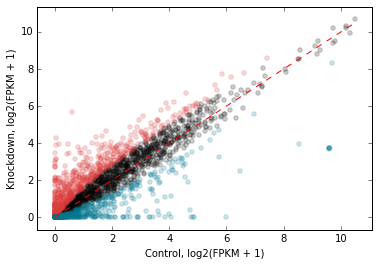

In [23]:
# Add a 1:1 line

d2.scatter(
    x='fpkm_ct',
    y='fpkm_kd',
    xfunc=log2p1,
    yfunc=log2p1,
    xlab='Control, log2(FPKM + 1)',
    ylab='Knockdown, log2(FPKM + 1)',
    genes_to_highlight=[
        (up, dict(color='#da3b3a')),
        (dn, dict(color='#00748e'))],
    #------------------------------------------
    one_to_one=dict(color='r', linestyle='--'),
    ); 

Let's change the plot style a bit.  The `general_kwargs` argument determines the base style of all points.  By default, it's ``dict(color='k', alpha=0.2, linewidths=0)``.  Let's change the default style to smaller gray dots, and make the red and blue stand out more by adjusting their alpha:

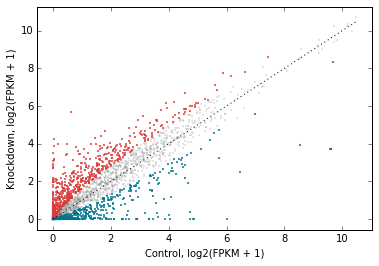

In [24]:
# Style changes:
# default gray small dots; make changed genes stand out more

d2.scatter(
    x='fpkm_ct',
    y='fpkm_kd',
    xfunc=log2p1,
    yfunc=log2p1,
    xlab='Control, log2(FPKM + 1)',
    ylab='Knockdown, log2(FPKM + 1)',
    one_to_one=dict(color='k', linestyle=':'),
    #------------------------------------------------------
    genes_to_highlight=[
        (up, dict(color='#da3b3a', alpha=0.8)),
        (dn, dict(color='#00748e', alpha=0.8))],
    general_kwargs=dict(marker='.', color='0.5', alpha=0.2, s=5),
    ); 

##Marginal histograms
:mod:`metaseq` also offers support for marginal histograms, which are stacked up on either axes for each set of genes that were plotted.  There are lots of ways for configuring this.  First, let's turn them on for everything:

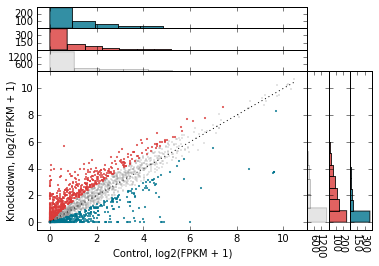

In [25]:
# Add marginal histograms

d2.scatter(
    x='fpkm_ct',
    y='fpkm_kd',
    xfunc=log2p1,
    yfunc=log2p1,
    xlab='Control, log2(FPKM + 1)',
    ylab='Knockdown, log2(FPKM + 1)',
    genes_to_highlight=[
        (up, dict(color='#da3b3a', alpha=0.8)),
        (dn, dict(color='#00748e', alpha=0.8))],
    one_to_one=dict(color='k', linestyle=':'),
    general_kwargs=dict(marker='.', color='0.5', alpha=0.2, s=5),
    #------------------------------------------------------
    marginal_histograms=True,
    ); 

As a contrived example to illustrate the flexibility for plotting marginal histograms, lets:

* only show histograms for up/down regulated
* change the number of bins to 50
* remove the edge around each bar

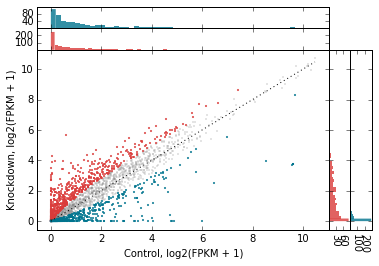

In [26]:
# Tweak the marginal histograms:
# 50 bins, don't show unchanged genes, and remove outlines

d2.scatter(
    x='fpkm_ct',
    y='fpkm_kd',
    xfunc=log2p1,
    yfunc=log2p1,
    xlab='Control, log2(FPKM + 1)',
    ylab='Knockdown, log2(FPKM + 1)',
    one_to_one=dict(color='k', linestyle=':'),
    general_kwargs=dict(marker='.', color='0.5', alpha=0.2, s=5),
    #------------------------------------------------------
    # Go back go disabling them globally...
    marginal_histograms=False,

    # ...and then turn them back on for each set of genes 
    # to highlight.
    # 
    # By the way, genes_to_highlight is indented to better show the
    # the structure.
    genes_to_highlight=[
    (
     up,
     dict(
          color='#da3b3a', alpha=0.8, 
          marginal_histograms=True, 
          xhist_kwargs=dict(bins=50, linewidth=0),
          yhist_kwargs=dict(bins=50, linewidth=0),
          )
     ),
    (
     dn,
     dict(
          color='#00748e', alpha=0.8,
          marginal_histograms=True, 
          xhist_kwargs=dict(bins=50, linewidth=0),
          yhist_kwargs=dict(bins=50, linewidth=0),
          )
     )
    ],
); 


Let's clean up the plot by adding a legend (using `label` in `genes_to_highlight`), and adding it outside the axes.  While we're at it we'll add a title, too.

There's a trick here -- for each set of genes, the histograms are incrementally added on top of each other but the legend, lists them going down.  So we need to flip the order of legend entries to make it nicely match the order of the histograms.

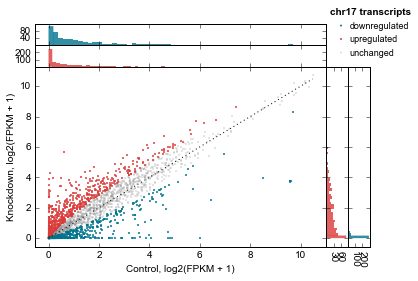

In [27]:
matplotlib.rcParams['font.family'] = "Arial"
ax = d2.scatter(
    x='fpkm_ct',
    y='fpkm_kd',
    xfunc=log2p1,
    yfunc=log2p1,
    xlab='Control, log2(FPKM + 1)',
    ylab='Knockdown, log2(FPKM + 1)',
    one_to_one=dict(color='k', linestyle=':'),
    marginal_histograms=False,
    #------------------------------------------------------
    # add the "unchanged" label
    general_kwargs=dict(marker='.', color='0.5', alpha=0.2, s=5, label='unchanged'),

    genes_to_highlight=[
    (
     up,
     dict(
          color='#da3b3a', alpha=0.8, 
          marginal_histograms=True, 
          xhist_kwargs=dict(bins=50, linewidth=0),
          yhist_kwargs=dict(bins=50, linewidth=0),
          
          # add label
          label='upregulated',
          )
     ),
    (
     dn,
     dict(
          color='#00748e', alpha=0.8,
          marginal_histograms=True, 
          xhist_kwargs=dict(bins=50, linewidth=0),
          yhist_kwargs=dict(bins=50, linewidth=0),
          
          # add label
          label='downregulated'
          )
     )
    ],
); 

# Get handles and labels, and then reverse their order
handles, legend_labels = ax.get_legend_handles_labels()
handles = handles[::-1]
legend_labels = legend_labels[::-1]

# Draw a legend using the flipped handles and labels.
leg = ax.legend(handles,
          legend_labels,
          
          # These values may take some tweaking.
          # By default they are in axes coordinates, so this means
          # the legend is slightly outside the axes.
          loc=(1.01, 1.05),
          
          # Various style fixes to default legend.
          fontsize=9,
          scatterpoints=1,
          borderpad=0.1,
          handletextpad=0.05, 
          frameon=False,
          title='chr17 transcripts',
          );

# Adjust the legend title after it's created
leg.get_title().set_weight('bold')


We'd also like to add a title.  But how to access the top-most axes?

Whenever the `scatter` method is called, the `MarginalHistograms` object created as a by-product of the plotting is stored in the `marginal` attribute.  This, in turn, has a `top_hists` attribute, and we can grab the last one created.  While we're at it, let's histograms axes as well.

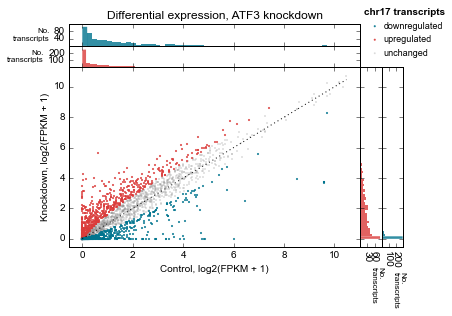

In [28]:

# Another trick: every time `d2.scatter` is called, 
top_axes = d2.marginal.top_hists[-1]
top_axes.set_title('Differential expression, ATF3 knockdown');

for ax in d2.marginal.top_hists:
    ax.set_ylabel('No.\ntranscripts', rotation=0, ha='right', va='center', size=8)

for ax in d2.marginal.right_hists:
    ax.set_xlabel('No.\ntranscripts', rotation=-90, ha='left', va='top', size=8)
    
fig = ax.figure
fig.savefig('expression-demo.png')
fig
